## Install Python libraries

In [1]:
!pip install --quiet datasets
!pip install --quiet sentence-transformers

     |████████████████████████████████| 290 kB 5.3 MB/s 
     |████████████████████████████████| 125 kB 41.9 MB/s 
     |████████████████████████████████| 1.3 MB 37.1 MB/s 
     |████████████████████████████████| 243 kB 52.0 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 271 kB 50.0 MB/s 
     |████████████████████████████████| 160 kB 44.1 MB/s 
     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 3.1 MB 11.2 MB/s 
     |████████████████████████████████| 3.3 MB 50.3 MB/s 
     |████████████████████████████████| 1.2 MB 33.9 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 


In [2]:
import torch
import random 
import pandas as pd
from datasets import load_dataset

## Load ELI5 models

In [3]:
kilt_eli5 = load_dataset("kilt_tasks", name="eli5")

Downloading:   0%|          | 0.00/2.96k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.44k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset kilt_tasks downloaded and prepared to /root/.cache/huggingface/datasets/kilt_tasks/eli5/1.0.0/57dc8b2431e76637e0c6ef79689ca4af61ed3a330e2e0cd62c8971465a35db3a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
eli5_ds = load_dataset("vblagoje/eli5v1", data_files={"train": "train.json", "validation": "validation.json", "test": "test.json"})

Using custom data configuration vblagoje___eli5v1-8f9f47da018bbede


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/687M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/37.9M [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/vblagoje___eli5v1-8f9f47da018bbede/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Load SBERT's SentenceTransformer 

In [5]:
from sentence_transformers import SentenceTransformer, util

embedder = SentenceTransformer('all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Encode our datasets using SentenceTransformer

In [6]:
new_eli5_train = embedder.encode([example["title"] for example in eli5_ds["train"]], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/7068 [00:00<?, ?it/s]

In [7]:
new_eli5_validation = embedder.encode([example["title"] for example in eli5_ds["validation"]], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/95 [00:00<?, ?it/s]

In [8]:
new_eli5_test = embedder.encode([example["title"] for example in eli5_ds["test"]], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [9]:
old_eli5_train = embedder.encode([example["input"] for example in kilt_eli5["train"]], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/8520 [00:00<?, ?it/s]

In [10]:
old_eli5_validation = embedder.encode([example["input"] for example in kilt_eli5["validation"]], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

In [11]:
old_eli5_test = embedder.encode([example["input"] for example in kilt_eli5["test"]], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

## Extract train/validation similarity scores

In [12]:
 def extract_scores_dist(similarity_scores, topk=3):
  extracted_sim_scores = []
  for depth in range(0, topk): 
    extracted_sim_scores.append(similarity_scores[0][depth]["score"])
  return extracted_sim_scores  

In [13]:
sample_similarities_train_validation = []
for item in new_eli5_validation:    
  scores = util.semantic_search(item, new_eli5_train, score_function=util.cos_sim)  
  sample_similarities_train_validation.append(extract_scores_dist(scores))

sample_similarities_train_test = []
for item in new_eli5_test:    
  scores = util.semantic_search(item, new_eli5_train, score_function=util.cos_sim)  
  sample_similarities_train_test.append(extract_scores_dist(scores))

In [14]:
old_sample_similarities_train_validation = []
for item in old_eli5_validation:    
  scores = util.semantic_search(item, old_eli5_train, score_function=util.cos_sim)  
  old_sample_similarities_train_validation.append(extract_scores_dist(scores))

In [15]:
old_sample_similarities_train_test = []
for item in old_eli5_test:    
  scores = util.semantic_search(item, old_eli5_train, score_function=util.cos_sim)  
  old_sample_similarities_train_test.append(extract_scores_dist(scores))

## Plot similiary probability

In [16]:
df = pd.DataFrame(
    {
        "topk=1": [item[0] for item in sample_similarities_train_validation],
        "topk=2": [item[1] for item in sample_similarities_train_validation],
        "topk=3": [item[2] for item in sample_similarities_train_validation]
    }
)

old_df = pd.DataFrame(
    {
        "topk=1": [item[0] for item in old_sample_similarities_train_validation],
        "topk=2": [item[1] for item in old_sample_similarities_train_validation],
        "topk=3": [item[2] for item in old_sample_similarities_train_validation]
    }
)

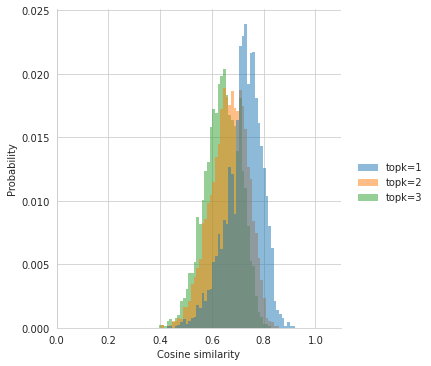

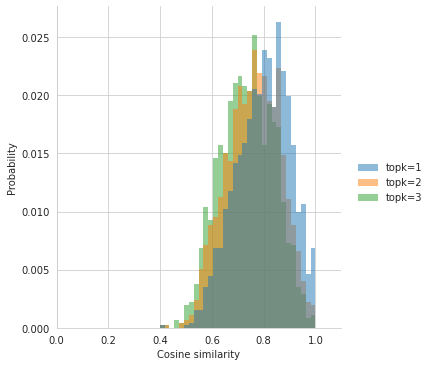

In [17]:
import seaborn as sns
sns.set_style("whitegrid")

plot = sns.displot(data=df, stat="probability", alpha=.5, linewidth=0)
plot.set(xlim=(0.0, 1.1))
plot.set_xlabels('Cosine similarity');

old_plot = sns.displot(data=old_df, stat="probability", alpha=.5, linewidth=0)
old_plot.set(xlim=(0.0, 1.1))
old_plot.set_xlabels('Cosine similarity');

In [18]:
df = pd.DataFrame(
    {
        "topk=1": [item[0] for item in sample_similarities_train_test],
        "topk=2": [item[1] for item in sample_similarities_train_test],
        "topk=3": [item[2] for item in sample_similarities_train_test]
    }
)

old_df = pd.DataFrame(
    {
        "topk=1": [item[0] for item in old_sample_similarities_train_test],
        "topk=2": [item[1] for item in old_sample_similarities_train_test],
        "topk=3": [item[2] for item in old_sample_similarities_train_test]
    }
)

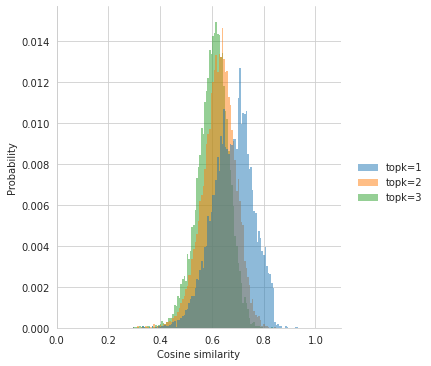

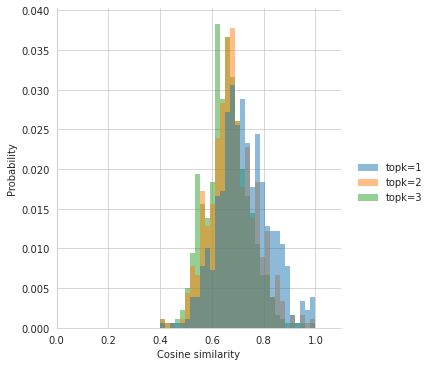

In [19]:
import seaborn as sns
sns.set_style("whitegrid")

plot = sns.displot(data=df, stat="probability", alpha=.5, linewidth=0)
plot.set(xlim=(0.0, 1.1))
plot.set_xlabels('Cosine similarity');

old_plot = sns.displot(data=old_df, stat="probability", alpha=.5, linewidth=0)
old_plot.set(xlim=(0.0, 1.1))
old_plot.set_xlabels('Cosine similarity');